In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack 2.0 - Characterizing aberrations

This tutorial demonstrates how to characterize the aberrations of an optical device using the image of a particle. We will specifically look at spherical aberrations, though the example can straightforwardly be extended to other aberrations.

It is recommended to read both [deeptrack_introdution_tutorial](./deeptrack_introdution_tutorial.ipynb) and [tracking_particle_cnn_tutorial](./tracking_particle_cnn_tutorial.ipynb) before reading this tutorial.

## 1. Setup

Imports needed for this tutorial.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

## 2. Define the features

We define the features needed for this example. 

* `fluorescence_microscope` - Flourescence microscope with a pixel size of 0.1 microns and a 128x128 camera (see also [optics_example](../examples/optics_example.ipynb))
* `particle` - Spherical particle roughly centered in the image, a micron out of focus (see also [features_example](../examples/features_example.ipynb))
* `aberration` - Spherical aberration with a coefficient between -4 and 4 (see also [aberrations_example](../examples/aberrations_example.ipynb))
* `noise` - A constant background illumantion and a Poisson noise with SNR 100 (see also [noises_example](../examples/noises_example.ipynb))
* `normalization` - Maps the image to values between 0 and 1

In particular, `SphericalAberration` is a wrapper of the more general `Zernike` feature, which introduces a phase to the pupil function based on the normalized Zernike polynomials. The property `coefficient` is a multiplier for the respective poynomial in the set of Zernike polynomials.

In [3]:
fluorescence_microscope = dt.Fluorescence(
    magnification=10,
    resolution=1e-6,
    wavelength=633e-9,
    output_region=(0, 0, 128, 128)
)

particle = dt.Sphere(
    position=lambda: np.random.randn(3) * (1, 1, 3) + (64, 64, 10),
    position_unit="pixel",
    intensity=10,
    radius=np.random.rand() * 1e-6 + 0.5e-6
)

aberration = dt.SphericalAberration(coefficient=lambda: (2 * np.random.rand() - 1) * 4)

noise = dt.Offset(offset=0.01) + dt.Poisson(snr=100)

normalization = dt.NormalizeMinMax(min=0, max=1)

## 3. Combine the features

To view the particle throught the aberrated microscope, we call `fluorescence_microscope` with both the particle and the aberration. Then we add the noise and normalization as usual.

By calling `.resolve` with a coefficient, we override the value that the aberration generated for itself. Here we show the aberration at different strengths.

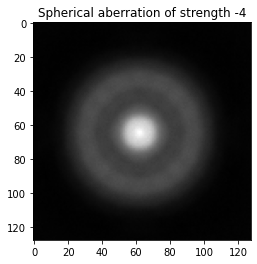

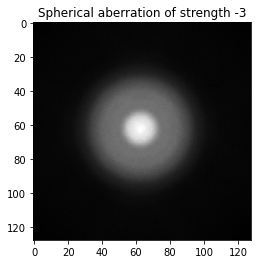

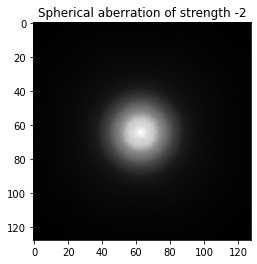

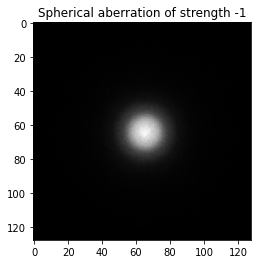

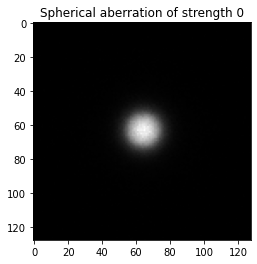

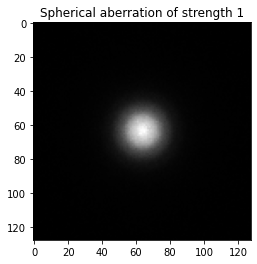

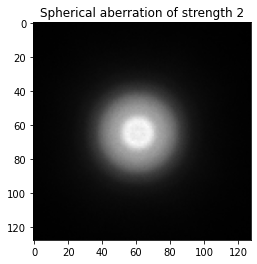

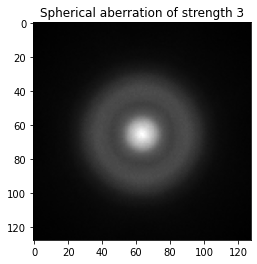

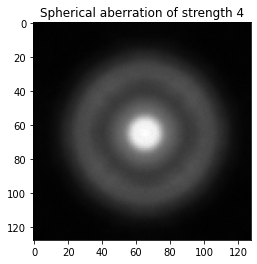

In [4]:
aberrated_particle = fluorescence_microscope(particle, aberration=aberration) + noise + normalization

for coefficient in range(-4, 5):
    aberrated_particle.update(coefficient=coefficient)
    
    plt.title("Spherical aberration of strength {0}".format(coefficient))
    aberrated_particle.plot(cmap="gray")  

## 4. Define the label function and the generator

We define a label function that iterates through all the properties and returns the coefficient of `SphericalAberration`.

In [5]:
def get_aberration(image):
    return image.get_property("coefficient")

We use this function to create a generator of spherically aberrated images of particles to be used to train the neural network model.

In [6]:
generator = dt.generators.ContinuousGenerator(
    aberrated_particle, 
    get_aberration, 
    batch_size=32,
    min_data_size=1024,
    max_data_size=2048
)

## 5. Create the model

We will use the standard convolution model for this task implemented by the function `convolutional` (see also [models_example](../examples/models_example.ipynb)). Since this is a regression task, we will use mean absolute error as loss.

In [7]:
model = dt.models.convolutional(
    input_shape=(128, 128, 1), 
    number_of_outputs=1,
)

## 6. Train the model

We train the model for 100 epochs. This will take some time (a few minutes).

In [8]:
with generator:
    model.fit(generator, epochs=100)

Generating 1026 / 1024 samples before starting training
Epoch 1/100
32/32 [==============================] - 0s 11ms/step - loss: 1.8080
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 1.6552
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 1.5575
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 1.3643
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 1.4343
Epoch 6/100
32/32 [==============================] - 0s 11ms/step - loss: 1.0202
Epoch 7/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8979
Epoch 8/100
32/32 [==============================] - 0s 13ms/step - loss: 0.7154
Epoch 9/100
32/32 [==============================] - 0s 11ms/step - loss: 0.5523
Epoch 10/100
32/32 [==============================] - 0s 11ms/step - loss: 0.4751
Epoch 11/100
32/32 [==============================] - 0s 11ms/step - loss: 0.3659
Epoch 12/100
32/32 [==============================]

32/32 [==============================] - 0s 12ms/step - loss: 0.0425


## 7. Validate the result

Finally, we validate the result by plotting the predicted value of the spherical aberration against the true value.

Text(0.5, 1.0, 'Spherical aberration coefficient')

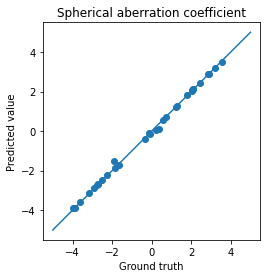

In [9]:
# generator[0] extracts as single batch from the generator
batch, labels = generator[0]

prediction = model.predict(batch)

plt.scatter(labels, prediction)
plt.plot([-5, 5], [-5, 5])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Ground truth")
plt.ylabel("Predicted value")
plt.title("Spherical aberration coefficient")  
plt.show()